# Comparing Distances

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import ast
from tqdm import tqdm

Plotting some distances as boxplots:

In [2]:
# all the different plot parameters:

distance_measure_names = ["kl_divergence",
                          "js_divergence", 
                          "wasserstein_distance",  
                          "hellinger_distance", 
                          "bhattacharyya", 
                          "histogram_correlation", 
                          "histogram_intersection"]

distances_short = ["kl","jsd", "wsd",  "hd", "bd", "hc", "hi"]

variables = ["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]
layers = ["dense1", "dense2"]

In [3]:
# open all the distances

def get_distances( d_measure_name, layer, variable):
                
    myFile = open(f'4b Distances/{layer}_{variable}_{d_measure_name}_distances.txt', 'r')
    distances = myFile.read()
    distances = ast.literal_eval(distances) 
    
    return distances

In [4]:

# plotting distances
def boxplotting(distances, distance_name):
    
    distances_boxes = []
    c_names = []

    for name in distances.keys():
        distances_boxes.append(distances[name])
        c_names.append(name)
    
    fig, ax = plt.subplots()
    ax.set_ylabel(distance_name)
    bplot = ax.boxplot(distances_boxes)
    plt.xticks(range(1,len(c_names)+1), c_names, rotation=70)
    plt.show()

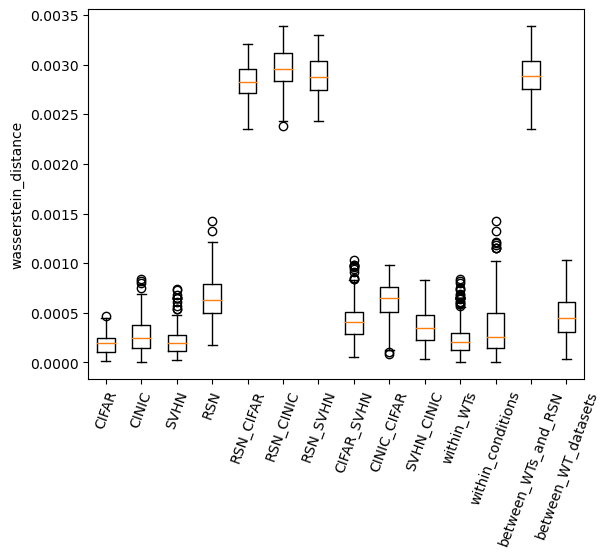

In [5]:
distances = get_distances("wasserstein_distance", "dense1", "prune_rate_in")
boxplotting(distances, "wasserstein_distance")

Plot means and stds:

In [6]:
distance_statistics = pd.read_csv(f'4b Distances/mean_std_distances.csv').rename(columns = {"Unnamed: 0":"condition"}, inplace = False)

In [7]:
# displaying a selected area of the mean and std tables

distance_statistics = distance_statistics[distance_statistics["distance_measure"] == "wasserstein_distance"]
distance_statistics =  distance_statistics[distance_statistics["layer"] == "dense1"]
distance_statistics =  distance_statistics[distance_statistics["variable"] == "prune_rate_in"]
display(distance_statistics)

,condition,mean,std,layer,variable,distance_measure
224,CIFAR,0.000191,0.000099,dense1,prune_rate_in,wasserstein_distance
225,CINIC,0.000291,0.000188,dense1,prune_rate_in,wasserstein_distance
226,SVHN,0.000233,0.000169,dense1,prune_rate_in,wasserstein_distance
227,RSN,0.000662,0.000239,dense1,prune_rate_in,wasserstein_distance
228,RSN_CIFAR,0.002823,0.000180,dense1,prune_rate_in,wasserstein_distance
229,RSN_CINIC,0.002960,0.000204,dense1,prune_rate_in,wasserstein_distance
230,RSN_SVHN,0.002880,0.000190,dense1,prune_rate_in,wasserstein_distance
231,CIFAR_SVHN,0.000419,0.000187,dense1,prune_rate_in,wasserstein_distance
232,CINIC_CIFAR,0.000621,0.000194,dense1,prune_rate_in,wasserstein_distance
233,SVHN_CINIC,0.000357,0.000161,dense1,prune_rate_in,wasserstein_distance


Display t-test results:

In [8]:
test_results = pd.read_csv(f'4b Distances/significance_test_results.csv')

In [9]:
def hypothesis_tables(results):
    
    new_dfs = []
    for layer in layers:

        results_l = results[results["layer"] == layer]
        
        # make new dataframe with the indexi
        new_df = results_l[results_l["distance_measure"] == "wasserstein_distance"][["variable","hypothesis"]]
        new_df = new_df.reset_index(drop=True)

        # apppend test results to dataframe
        for dm, dm_short in zip(distance_measure_names, distances_short):
            df = results_l[results_l["distance_measure"] == dm]
            df = df[["accepted", "p-value"]]
            df.rename(columns = {"accepted":f"accepted_{dm_short}", "p-value":f"p-value_{dm_short}"}, inplace = True)
            df = df.reset_index(drop=True)
            new_df = pd.concat([new_df, df], axis=1)

        new_df.set_index(["variable","hypothesis"])
        new_dfs.append(new_df)
        
        display(new_df)
        
    return new_dfs

In [10]:
def count_hypothesis_accepted(tables):
    
    h_count_tables= []
    for table in tables:
        # get the column names of the accepted values
        column_names = []
        for dm, dm_short in zip(distance_measure_names, distances_short):
            column_names.append("accepted_"+dm_short)

        # get the counts for each variable and hypothesis combination
        accepted_counts = []
        for index, row in table.iterrows():
            accepted = []
            for c in column_names:
                accepted.append(row[c])
            accepted_counts.append(np.sum(accepted))

        # turn into pandas series and append to dataframe
        counts = pd.Series(accepted_counts, index=range(16))
        h_counts = pd.concat([table[["variable","hypothesis"]], counts], axis=1)
        h_count_tables.append(h_counts)
        
        # display dataframe
        display(h_counts)
        
    return h_count_tables

In [11]:
# print tables

tables = hypothesis_tables(test_results)
h_counts = count_hypothesis_accepted(tables)

,variable,hypothesis,accepted_kl,p-value_kl,accepted_jsd,p-value_jsd,accepted_wsd,p-value_wsd,accepted_hd,p-value_hd,accepted_bd,p-value_bd,accepted_hc,p-value_hc,accepted_hi,p-value_hi
0,prune_rate_in,H1,True,3.104681e-175,True,3.528487e-82,True,0.000000e+00,True,6.519910e-76,True,2.370445e-106,False,1.000000e+00,True,4.127375e-106
1,prune_rate_in,H2,False,1.000000e+00,True,5.293713e-186,True,1.336485e-117,True,5.661468e-147,True,0.000000e+00,True,1.751960e-129,True,9.589213e-147
2,prune_rate_in,H3,False,9.999998e-01,True,1.215163e-26,True,7.603235e-64,True,1.667385e-26,True,6.470490e-26,True,6.344331e-11,True,6.256252e-30
3,prune_rate_in,H4,True,4.265219e-189,True,1.615508e-91,True,0.000000e+00,True,3.779099e-76,True,6.753406e-80,False,1.000000e+00,True,2.346765e-170
4,prune_rate_out,H1,True,3.265681e-199,True,5.539922e-128,True,0.000000e+00,True,1.327646e-152,True,3.396930e-117,True,4.891030e-14,True,6.185502e-139
5,prune_rate_out,H2,True,2.678871e-250,True,2.596460e-203,True,3.638143e-107,True,5.828427e-248,True,1.322599e-174,True,1.905152e-142,True,7.576735e-217
6,prune_rate_out,H3,True,9.724424e-76,True,6.530116e-167,True,1.581000e-154,True,6.400165e-171,True,1.247614e-160,True,7.877510e-108,True,2.317091e-167
7,prune_rate_out,H4,True,7.500046e-104,True,1.835160e-04,True,0.000000e+00,True,6.685777e-04,True,3.475187e-06,False,1.000000e+00,True,1.627541e-04
8,sign_rate_in,H1,False,8.679731e-01,True,8.821369e-09,True,1.146155e-101,True,7.101221e-09,False,NaN,True,1.955537e-03,True,8.826252e-09
9,sign_rate_in,H2,False,9.995680e-01,True,2.368122e-58,True,1.341676e-184,True,2.643972e-58,False,NaN,True,1.668854e-22,True,9.521683e-56


,variable,hypothesis,accepted_kl,p-value_kl,accepted_jsd,p-value_jsd,accepted_wsd,p-value_wsd,accepted_hd,p-value_hd,accepted_bd,p-value_bd,accepted_hc,p-value_hc,accepted_hi,p-value_hi
0,prune_rate_in,H1,True,3.067959e-92,True,2.862459e-60,True,9.851369e-255,True,8.465187e-60,True,5.466453e-59,True,4.702039e-43,True,5.841357e-60
1,prune_rate_in,H2,True,3.108688e-105,True,2.823059e-93,True,3.405454e-68,True,4.157764e-113,True,7.311227e-88,True,1.036328e-67,True,6.112702e-93
2,prune_rate_in,H3,True,8.512854e-119,True,1.001393e-141,True,8.911144e-49,True,2.249688e-144,True,3.657827e-136,True,3.499898e-141,True,1.012317e-143
3,prune_rate_in,H4,False,1.975436e-01,False,1.000000e+00,True,4.180625e-183,False,1.000000e+00,False,9.999999e-01,False,1.000000e+00,False,1.000000e+00
4,prune_rate_out,H1,True,6.121175e-29,True,5.893197e-20,True,4.773505e-24,True,2.049860e-16,True,1.383922e-17,True,4.983928e-04,True,2.754464e-11
5,prune_rate_out,H2,True,2.179222e-27,True,5.557910e-28,True,1.012975e-08,True,1.555657e-20,True,1.705283e-25,True,6.348027e-14,True,2.482094e-19
6,prune_rate_out,H3,True,3.318284e-21,True,1.468743e-21,True,1.429570e-12,True,1.910601e-18,True,2.328964e-18,True,6.214660e-17,True,9.433086e-20
7,prune_rate_out,H4,False,2.257226e-01,False,8.380562e-01,True,9.068292e-05,False,7.329426e-01,False,6.773625e-01,False,1.000000e+00,False,9.997943e-01
8,sign_rate_in,H1,False,8.546915e-01,True,1.254217e-49,True,6.683802e-39,True,1.721855e-48,True,2.481018e-51,True,1.984177e-07,True,6.856235e-51
9,sign_rate_in,H2,False,9.979521e-01,True,7.059826e-46,True,1.106179e-05,True,3.605690e-44,True,1.342689e-56,True,6.083851e-07,True,6.805534e-43


,variable,hypothesis,0
0,prune_rate_in,H1,6
1,prune_rate_in,H2,6
2,prune_rate_in,H3,6
3,prune_rate_in,H4,6
4,prune_rate_out,H1,7
5,prune_rate_out,H2,7
6,prune_rate_out,H3,7
7,prune_rate_out,H4,6
8,sign_rate_in,H1,5
9,sign_rate_in,H2,5


,variable,hypothesis,0
0,prune_rate_in,H1,7
1,prune_rate_in,H2,7
2,prune_rate_in,H3,7
3,prune_rate_in,H4,1
4,prune_rate_out,H1,7
5,prune_rate_out,H2,7
6,prune_rate_out,H3,7
7,prune_rate_out,H4,1
8,sign_rate_in,H1,6
9,sign_rate_in,H2,6


In [12]:
# store tables

tables[0].to_csv(f'4b Distances/hypotheses_table_dense1.csv', index=True)
tables[1].to_csv(f'4b Distances/hypotheses_table_dense2.csv', index=True)
h_counts[0].to_csv(f'4b Distances/hypotheses_counts_dense1.csv', index=True)
h_counts[1].to_csv(f'4b Distances/hypotheses_counts_dense2.csv', index=True)

Hypothesis:  

1. Distances within WTs are smaller than between WTs and RSNs
2. Distances within RSNs are smaller than between WTs and RSNs
3. Distances within WTs are smaller than between WT datasts
4. Distances between WT datasets are smaller than between WTs and RSNs